### Libraries

In [1]:
import cv2
import numpy as np
import tifffile 
import zarr 
import matplotlib.pyplot as plt
import json
import math

### Functions

### detect_rect_coord

In [10]:
def detect_rect_coord(image, show_image):
    """
    This function takes an image (numpy array), detects light rectangular contours, and draws them on the image.

    Parameters:
    image_np (numpy array): The input image in which to detect and draw rectangles.

    Returns:
    tuple: A tuple containing:
           - list of numpy arrays: The list of detected rectangles (each represented by its vertices).
           - numpy array: The image with detected rectangles drawn on it.
    """
    image_np = np.array(image)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    vertices = []
    areas = []
    for contour in contours:
        # Approximate the contour to a polygon
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        area = cv2.contourArea(approx)
        # If the polygon has 4 vertices, it is considered a rectangle
        if len(approx) == 4 and area > 1000:
            vertices.append(approx)
            areas.append(area)

    vertices_upd = [(vert[:,0,1].min(), vert[:,0,1].max(), vert[:,0,0].min(), vert[:,0,0].max()) for vert in vertices]

    combined = list(zip(areas, vertices_upd))
    combined.sort(key=lambda x: x[0], reverse=True)
    rect_dict = {}
    keys = ["rect_CA", "rect_1000", "rect_750", "rect_500", "rect_400", "rect_300"]
    for i, key in enumerate(keys):
        area, (y0, y1, x0, x1) = combined[i]
        rect_dict[key] = {
            'y0': y0,
            'y1': y1,
            'x0': x0,
            'x1': x1
        }

    if show_image:
        show_image = image_np.copy()
        for rect in vertices:
            cv2.drawContours(show_image, [rect], -1, (0, 255, 0), 20)

    return rect_dict, show_image

### detect_circ_coord

In [11]:
def sobel(image):
    """
    Computes the Sobel magnitude of the input image.

    Parameters:
    image: (numpy array): The input image.

    Returns:
    numpy array: The Sobel magnitude image.
    """
    # Apply Sobel operator to find the gradient in the x direction
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    
    # Apply Sobel operator to find the gradient in the y direction
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the magnitude of the gradient
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Convert the magnitude to 8-bit image
    sobel_magnitude = cv2.convertScaleAbs(sobel_magnitude)
    
    return sobel_magnitude

In [12]:
def clahe(image_np):
    """
    Enhances the contrast of the image using CLAHE.
    1. Convert the input image from the BGR color space to the LAB color space using `cv2.cvtColor`.
    2. Split the LAB image into its three channels: L, A, and B using `cv2.split`.
    3. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel to enhance the contrast.
       CLAHE works by limiting the contrast amplification to prevent noise amplification, which is done using the `clipLimit` and `tileGridSize` parameters.
    4. Merge the enhanced L channel back with the A and B channels using `cv2.merge`.
    5. Convert the LAB image back to the BGR color space using `cv2.cvtColor`.

    Parameters:
    image_np (numpy array): The input image.

    Returns:
    numpy array: The image with enhanced contrast.
    """
    # Convert the image to the LAB color space
    lab = cv2.cvtColor(image_np, cv2.COLOR_BGR2LAB)

    # Split the LAB image into its channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L channel back with the A and B channels
    limg = cv2.merge((cl, a, b))

    # Convert the LAB image back to the BGR color space
    clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return clahe

In [13]:
def group_and_average(coordinates, threshold=10):
    def distance(coord1, coord2):
        return np.linalg.norm(np.array(coord1) - np.array(coord2))

    unique_groups = []
    for coord in coordinates:
        placed = False
        for group in unique_groups:
            if all(distance(coord, member) <= threshold for member in group):
                group.append(coord)
                placed = True
                break
        if not placed:
            unique_groups.append([coord])
    
    mean_values = [np.mean(group, axis=0).astype(int).tolist() for group in unique_groups]
    return mean_values

In [14]:
def is_circle(contour, width, tolerance=0.2):
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    if perimeter < int(width / 6):
        return False
    circularity = 4 * np.pi * (area / (perimeter * perimeter))
    return 1 - tolerance <= circularity <= 1 + tolerance

In [15]:
def circ_to_dict(circles_coord, size):
    # Sort by y-coordinate
    sorted_by_y = sorted(circles_coord, key=lambda item: item[1])

    # Sort each subgroup of 4 by x-coordinate
    n = 4
    for i in range(0, len(sorted_by_y), n):
        subgroup = sorted_by_y[i:i+n]
        sorted_subgroup = sorted(subgroup, key=lambda item: item[0])
        sorted_by_y[i:i+n] = sorted_subgroup

    # Characters and numbers for generating keys
    characters = ['A', 'B', 'C', 'D']
    numbers = [6, 5, 4, 3, 2, 1]

    # Dictionary to hold the result
    result_dict = {}
    index = 0

    # Generate keys and fill the dictionary
    for num in numbers:
        for char in characters:
            if index < len(sorted_by_y):
                key = f"{char}{num}{size}"
                x, y, radius = sorted_by_y[index]
                result_dict[key] = {
                    'x_centroid': x,
                    'y_centroid': y,
                    'radius': radius
                }
                index += 1

    return result_dict

In [16]:
def detect_circ_coord(image, width, show_image, rect_name):

    sobel_ = sobel(image)
    enhanced = clahe(clahe(sobel_))

    gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    circles = [contour for contour in contours if is_circle(contour, width)]

    circles_coord = []
    for contour in circles:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        circles_coord.append([center[0], center[1], radius])

    mean_radius = int(np.mean([c[2] for c in circles_coord]))
    circles_coord = group_and_average(circles_coord, threshold=10)
    for contour in circles_coord:
        contour[2] = mean_radius

    circles_coord_dict = circ_to_dict(circles_coord, rect_name)
    
    if show_image:
        show_image = image.copy()

        for contour in circles_coord:
            x, y, radius = contour[0], contour[1], mean_radius
            center = (int(x), int(y))
            cv2.circle(show_image, center, radius, (0, 255, 0), 2)

    return circles_coord_dict, show_image

### settle

In [30]:
def flip(image, position):

    y1000_more_than_yCA = False
    x1000_more_than_x500 = False
    
    rect_dict, _ = detect_rect_coord(image, show_image=True)

    if rect_dict["rect_1000"]["y0"] > rect_dict["rect_CA"]["y0"]:
        y1000_more_than_yCA = True
    if rect_dict["rect_1000"]["x0"] > rect_dict["rect_500"]["x0"]:
        x1000_more_than_x500 = True

    if y1000_more_than_yCA and x1000_more_than_x500:
        position['flip_horizontal'] = True
        flipped = cv2.flip(image, 1)
    elif not y1000_more_than_yCA and not x1000_more_than_x500:
        position['flip_vertical'] = True
        flipped = cv2.flip(image, 0)
    elif not y1000_more_than_yCA and x1000_more_than_x500:   
        position['flip_over'] = True
        flipped = cv2.rotate(image, cv2.ROTATE_180)
    else:
        flipped = image

    return flipped

def rotate(image, show_lines, h, w, position):

	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	edges = cv2.Canny(gray, 50, 150, apertureSize=3)
	lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

	theta_array = []
	for r_theta in lines:
		r, theta = np.array(r_theta[0], dtype=np.float64)
		# if normal is vertical (means that detected lines are horizontal)
		if np.pi/2 - 0.1 < theta < np.pi/2 + 0.1 or 3*np.pi/2 - 0.1 < theta < 3*np.pi/2 + 0.1:
			theta_array.append(theta)
	theta_deg_mean = np.mean(np.rad2deg(theta_array))
	angle_to_rotate = 90-theta_deg_mean
	position['rotation_angle'] = angle_to_rotate

	center = (w / 2, h / 2)
	matrix = cv2.getRotationMatrix2D(center, angle=-angle_to_rotate, scale=1.0)
	image_rotated = cv2.warpAffine(image, matrix, (w, h))

	if show_lines:
		show_lines = image.copy()
		for r_theta in lines:
			r, theta = np.array(r_theta[0], dtype=np.float64)

			# if normal is vertical (means that detected lines are horizontal)
			if np.pi/2 - 0.1 < theta < np.pi/2 + 0.1 or 3*np.pi/2 - 0.1 < theta < 3*np.pi/2 + 0.1:
					
				a = np.cos(theta)
				b = np.sin(theta)
				x0 = a*r
				y0 = b*r
				x1 = int(x0 + 1000*(-b))
				y1 = int(y0 + 1000*(a))
				x2 = int(x0 - 1000*(-b))
				y2 = int(y0 - 1000*(a))
				cv2.line(show_lines, (x1, y1), (x2, y2), (0, 0, 255), 50)

	return image_rotated

def settle(image, show_lines, h, w, position):
    return rotate(flip(image, position = position),show_lines=False, h = h, w = w, position = position)

### unsettle

In [18]:
def flip_horizontal_dict(points_dict, width, type):
    """
    Flip the x_centroid of all points in the dictionary horizontally.

    Parameters:
    points_dict (dict): Dictionary containing points with their coordinates.
    width (float): The width of the image.

    Returns:
    dict: The updated dictionary with horizontally flipped coordinates.
    """
    flipped_dict = {}

    if type == 'circle':
        for key, value in points_dict.items():
            x_new = width - value['x_centroid']
            flipped_dict[key] = {
                'x_centroid': x_new,
                'y_centroid': value['y_centroid'],
                'radius': value['radius']
            }
    if type == 'rectangle':
        for key, value in points_dict.items():
            x0_new = width - value['x0']
            x1_new = width - value['x1']
            flipped_dict[key] = {
                'y0': value['y0'],
                'y1': value['y1'],
                'x0': x0_new,
                'x1': x1_new,
            }

    return flipped_dict

def flip_vertical_dict(points_dict, height, type):
    """
    Flip the y_centroid of all points in the dictionary vertically.

    Parameters:
    points_dict (dict): Dictionary containing points with their coordinates.
    height (float): The height of the image.

    Returns:
    dict: The updated dictionary with vertically flipped coordinates.
    """
    flipped_dict = {}

    if type == 'circle':
        for key, value in points_dict.items():
            y_new = height - value['y_centroid']
            flipped_dict[key] = {
                'x_centroid': value['x_centroid'],
                'y_centroid': y_new,
                'radius': value['radius']
            }
    if type == 'rectangle':
        for key, value in points_dict.items():
            y0_new = height - value['y0']
            y1_new = height - value['y1']
            flipped_dict[key] = {
                'y0': y0_new,
                'y1': y1_new,
                'x0': value['x0'],
                'x1': value['x1'],
            }

    return flipped_dict

def rotate_point(x, y, cx, cy, theta):
    """
    Rotate a point around a given center by a specified angle.

    Parameters:
    x (float): The x-coordinate of the point.
    y (float): The y-coordinate of the point.
    cx (float): The x-coordinate of the center of rotation.
    cy (float): The y-coordinate of the center of rotation.
    theta (float): The rotation angle in degrees.

    Returns:
    (float, float): The new coordinates after rotation.
    """
    # Convert angle to radians
    theta = np.radians(theta)
    
    # Step 1: Translate point to origin
    x_origin = x - cx
    y_origin = y - cy
    
    # Step 2: Apply rotation matrix
    x_rotated = x_origin * np.cos(theta) - y_origin * np.sin(theta)
    y_rotated = x_origin * np.sin(theta) + y_origin * np.cos(theta)
    
    # Step 3: Translate point back
    x_new = x_rotated + cx
    y_new = y_rotated + cy
    
    return x_new, y_new

def rotate_points_dict(points_dict, width, height, theta, type):
    """
    Rotate the x_centroid and y_centroid of all points in the dictionary.

    Parameters:
    points_dict (dict): Dictionary containing points with their coordinates.
    width (float): The width of the image.
    height (float): The height of the image.
    theta (float): The rotation angle in degrees.

    Returns:
    dict: The updated dictionary with rotated coordinates.
    """
    cx = int(width/2)
    cy = int(height/2)
    rotated_dict = {}

    if type == 'circle':
        for key, value in points_dict.items():
            x_new, y_new = rotate_point(value['x_centroid'], value['y_centroid'], cx, cy, theta)
            rotated_dict[key] = {
                'x_centroid': x_new,
                'y_centroid': y_new,
                'radius': value['radius']
            }

    if type == 'rectangle':
        for key, value in points_dict.items():
            x0_new, y0_new = rotate_point(value['x0'], value['y0'], cx, cy, theta)
            x1_new, y1_new = rotate_point(value['x1'], value['y1'], cx, cy, theta)
            rotated_dict[key] = {
                'y0': y0_new,
                'y1': y1_new,
                'x0': x0_new,
                'x1': x1_new,
            }
    return rotated_dict

def unsettle(circ_dicts, position, w, h, type):
    coord_upd = circ_dicts.copy()

    if position.get('flip_horizontal'):
        print('Flip horizontal')
        coord_upd = flip_horizontal_dict(coord_upd, w, type)

    if position.get('flip_vertical'):
        print('Flip vertical')
        coord_upd = flip_vertical_dict(coord_upd, h, type)

    if position.get('flip_over'):
        print('Flip over')
        coord_upd = rotate_points_dict(coord_upd, w, h, 180, type)

    rotation_angle = position.get('rotation_angle', 0)
    if rotation_angle != 0:
        print('Rotation angle:', rotation_angle)
        coord_upd = rotate_points_dict(coord_upd, w, h, rotation_angle, type)

    return coord_upd

### scale

In [19]:
def scale(zarr_scaled, zarr_light, obj_coord_light):
    scale_factor = round(zarr_scaled.shape[0] / zarr_light.shape[0])
    
    obj_coord_scaled = {
        outer_key: {
            inner_key: int(value * scale_factor)
            for inner_key, value in inner_dict.items()
        }
        for outer_key, inner_dict in obj_coord_light.items()
    }
    
    return obj_coord_scaled

### 1. Download

In [1]:
import cv2
import numpy as np
import tifffile 
import zarr 
import matplotlib.pyplot as plt
import json
import math

In [2]:
tiff_storage = tifffile.imread('/uftp/src/palettes/IHCjul23_020723_2.ome.tiff', aszarr=True)
zarr_storage = zarr.open(tiff_storage, mode='r')

zarr_light = zarr_storage[len(zarr_storage)-2] 
zarr_scaled = zarr_storage[1] 

In [3]:
odl = np.array(zarr_light)
h, w = odl.shape[:2]
position = {'flip_vertical' : False,
            'flip_horizontal' : False,
            'flip_over' : False,
            'rotation_angle' : 0}
position

{'flip_vertical': False,
 'flip_horizontal': False,
 'flip_over': False,
 'rotation_angle': 0}

{'rect_CA': {'y0': 2417, 'y1': 3013, 'x0': 251, 'x1': 2528}, 'rect_1000': {'y0': 4250, 'y1': 5472, 'x0': 1738, 'x1': 2424}, 'rect_750': {'y0': 4556, 'y1': 5473, 'x0': 956, 'x1': 1469}, 'rect_500': {'y0': 4865, 'y1': 5476, 'x0': 356, 'x1': 698}, 'rect_400': {'y0': 3581, 'y1': 4069, 'x0': 316, 'x1': 589}, 'rect_300': {'y0': 3591, 'y1': 3954, 'x0': 950, 'x1': 1151}}


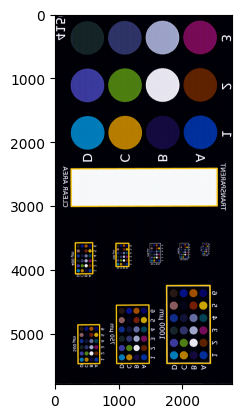

In [4]:
from colour_lib.palette_parser.DetectRectangles import RectangleDetector
rect_detector = RectangleDetector()

image = odl
image_processed = rect_detector.processing(image=image)
rect_coordinates, rect_image_to_show = rect_detector.detect_coordinates(image_to_find=image_processed, show_image=True, image_to_show=odl)
print(rect_coordinates)
plt.imshow(rect_image_to_show)

In [5]:
from colour_lib.palette_parser.Settle import Settle
settle = Settle()
flipped_image = settle.flip(image_to_flip=odl, position_pattern=rect_coordinates)
rotated_image, rot_image_to_show = settle.rotate(image_to_rotate=flipped_image, show_image=True, image_to_show=flipped_image)
settled_image = rotated_image

In [6]:
settle.position

{'flip_horizontal': True,
 'flip_vertical': False,
 'flip_over': False,
 'rotation_angle': -0.05555774536722424}

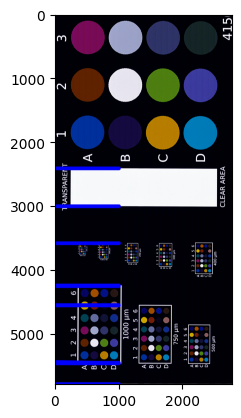

In [7]:
plt.imshow(rot_image_to_show)

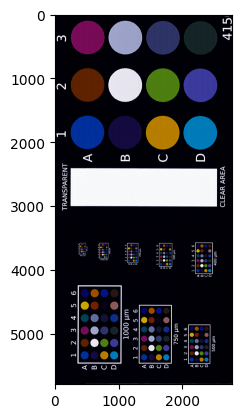

In [8]:
plt.imshow(settled_image)

{'rect_CA': {'y0': 2418, 'y1': 3012, 'x0': 246, 'x1': 2523}, 'rect_1000': {'y0': 4251, 'y1': 5473, 'x0': 353, 'x1': 1037}, 'rect_750': {'y0': 4556, 'y1': 5473, 'x0': 1307, 'x1': 1819}, 'rect_500': {'y0': 4864, 'y1': 5475, 'x0': 2078, 'x1': 2420}, 'rect_400': {'y0': 3580, 'y1': 4068, 'x0': 2186, 'x1': 2459}, 'rect_300': {'y0': 3590, 'y1': 3954, 'x0': 1623, 'x1': 1825}}


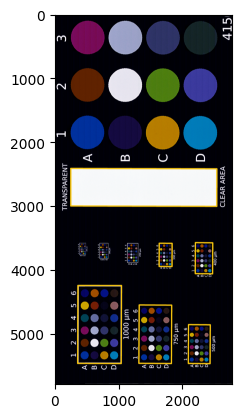

In [9]:
image = settled_image
image_processed = rect_detector.processing(image=image)
rect_coordinates, rect_image_to_show = rect_detector.detect_coordinates(image_to_find=image_processed, show_image=True, image_to_show=image)
print(rect_coordinates)
plt.imshow(rect_image_to_show)

In [10]:
from colour_lib.palette_parser.CircleTools import CircleTools
circle_tools = CircleTools()

In [11]:
circ_coordinates = {}
rect_coordinates_with_circles = [key for key in rect_coordinates if 'CA' not in key]

for rect_name in rect_coordinates_with_circles:

    coords = rect_coordinates[rect_name]
    crop = np.array(settled_image)[coords['y0']:coords['y1'],coords['x0']:coords['x1']]

    crop_sobel = circle_tools.preprocessing_sobel(image=crop)
    crop_clahe = circle_tools.preprocessing_clahe(crop_sobel)
    crop_clahe = circle_tools.preprocessing_clahe(crop_clahe)
    crop_general = circle_tools.preprocessing_general(crop_clahe) 
    crop_circ_coordinates = circle_tools.detect_coordinates(crop_general, averaging_threshold=10)
    crop_circ_coordinates = circle_tools.coordinates_to_dict(crop_circ_coordinates, rect_name=rect_name[4:])
    
    for key, value in crop_circ_coordinates.items():
        if 'x_centroid' in value:
            value['x_centroid'] += coords['x0']
            value['y_centroid'] += coords['y0']
    
    circ_coordinates.update(crop_circ_coordinates)

### unsettle

In [12]:
from colour_lib.palette_parser.Unsettle import Unsettle

In [24]:
unsettle = Unsettle()
rect_coord_light = unsettle.unsettle(coordinates = rect_coordinates, position = settle.position, w = w, h = h, type = 'rectangle')

Flip horizontal
Rotation angle: -0.05555774536722424


In [25]:
rect_coord_light

{'rect_CA': {'y0': 2416.8928672694747,
  'y1': 3013.100516198248,
  'x0': 2528.534993375706,
  'x1': 252.11204511700794},
 'rect_1000': {'y0': 4249.995759730165,
  'y1': 5472.658436390548,
  'x0': 2423.312440411767,
  'x1': 1740.4976931327785},
 'rect_750': {'y0': 4555.92067716177,
  'y1': 5473.416714756564,
  'x0': 1469.6086368676758,
  'x1': 958.4980607710238},
 'rect_500': {'y0': 4864.668144409364,
  'y1': 5475.999482739555,
  'x0': 698.9076562868829,
  'x1': 357.50028264738876},
 'rect_400': {'y0': 3580.7734719170835,
  'y1': 4069.0379611580793,
  'x0': 589.6626566487322,
  'x1': 317.1359817227178},
 'rect_300': {'y0': 3590.2275455789127,
  'y1': 3954.4232468699793,
  'x0': 1152.6720886222975,
  'x1': 951.0251418040818}}

In [20]:
rect_coord_light

{'rect_CA': {'y0': 2418, 'y1': 3012, 'x0': 246, 'x1': 2523},
 'rect_1000': {'y0': 4251, 'y1': 5473, 'x0': 353, 'x1': 1037},
 'rect_750': {'y0': 4556, 'y1': 5473, 'x0': 1307, 'x1': 1819},
 'rect_500': {'y0': 4864, 'y1': 5475, 'x0': 2078, 'x1': 2420},
 'rect_400': {'y0': 3580, 'y1': 4068, 'x0': 2186, 'x1': 2459},
 'rect_300': {'y0': 3590, 'y1': 3954, 'x0': 1623, 'x1': 1825}}

In [22]:
rect_coord_light = unsettle(rect_coord, position, w, h, type = 'rectangle')
circle_coord_light = unsettle(circ_coord, position, w, h, type = 'circle')
obj_coord_light = {**rect_coord_light, **circle_coord_light}

Flip horizontal
Rotation angle: -0.05555774536722424
Flip horizontal
Rotation angle: -0.05555774536722424


### show

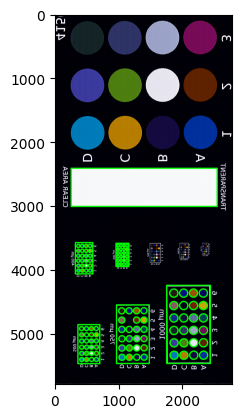

In [23]:
odl_copy = odl.copy()
for key, value in rect_coord_light.items():
        y0, y1, x0, x1 = value['y0'], value['y1'], value['x0'], value['x1']
        contour = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]], dtype=np.int32).reshape((-1, 1, 2))
        contours = [contour]
        cv2.drawContours(odl_copy, contours, -1, (0, 255, 0), 20)
for key, value in circle_coord_light.items():
        x, y, radius = value['x_centroid'], value['y_centroid'], value['radius']
        center = (int(x), int(y))
        cv2.circle(odl_copy, center, radius, (0, 255, 0), 20)
plt.imshow(odl_copy)

### scale

In [31]:
obj_coord_scaled = scale(zarr_scaled, zarr_light, obj_coord_light)
print(obj_coord_scaled)

{'rect_CA': {'y0': 9667, 'y1': 12052, 'x0': 10114, 'x1': 1008}, 'rect_1000': {'y0': 16999, 'y1': 21890, 'x0': 9693, 'x1': 6961}, 'rect_750': {'y0': 18223, 'y1': 21893, 'x0': 5878, 'x1': 3833}, 'rect_500': {'y0': 19458, 'y1': 21903, 'x0': 2795, 'x1': 1430}, 'rect_400': {'y0': 14323, 'y1': 16276, 'x0': 2358, 'x1': 1268}, 'rect_300': {'y0': 14360, 'y1': 15817, 'x0': 4610, 'x1': 3804}, 'A6_1000': {'x_centroid': 9249, 'y_centroid': 17480, 'radius': 256}, 'B6_1000': {'x_centroid': 8633, 'y_centroid': 17481, 'radius': 256}, 'C6_1000': {'x_centroid': 8021, 'y_centroid': 17485, 'radius': 256}, 'D6_1000': {'x_centroid': 7409, 'y_centroid': 17486, 'radius': 256}, 'A5_1000': {'x_centroid': 9250, 'y_centroid': 18260, 'radius': 256}, 'B5_1000': {'x_centroid': 8638, 'y_centroid': 18261, 'radius': 256}, 'C5_1000': {'x_centroid': 8026, 'y_centroid': 18261, 'radius': 256}, 'D5_1000': {'x_centroid': 7410, 'y_centroid': 18266, 'radius': 256}, 'A4_1000': {'x_centroid': 9255, 'y_centroid': 19036, 'radius': 

### mean_rgb

In [32]:
def mean_rgb_circ(image, x, y, r, margin = 0.3):

    r = int(r*margin)

    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
    
    dist_from_center = np.sqrt((X - x)**2 + (Y - y)**2)
    
    mask = dist_from_center <= r
    
    mean_color = []
    for i in range(image.shape[2]): 
        channel_mean = image[:, :, i][mask].mean()
        mean_color.append(channel_mean)
    
    return np.array(mean_color)

def mean_rgb_rect(image, y0, y1, x0, x1, margin=0.3):

    y0, y1 = sorted([y0, y1])
    x0, x1 = sorted([x0, x1])

    h = y1 - y0
    w = x1 - x0

    y0_m, y1_m = int(y0 + h*margin), int(y1 - h*margin)
    x0_m, x1_m = int(x0 + w * margin), int(x1 - w * margin)

    region = image[y0_m:y1_m, x0_m:x1_m]
    mean_color = region.mean(axis=(0, 1))

    return np.array(mean_color)

In [33]:
obj_rgb = {}

filter = "_1000"
obj_coord_scaled_filtred = {key: value for key, value in obj_coord_scaled.items() if (filter in key) and ("rect" not in key)}
obj_coord_scaled_filtred['CA'] = obj_coord_scaled['CA']

image = zarr_scaled
for i, (key, values) in enumerate(obj_coord_scaled_filtred.items()):
    print(key)
    if key == 'CA':
        
        x0 = values['x0']
        x1 = values['x1']
        y0 = values['y0']
        y1 = values['y1']

        mean_color = mean_rgb_rect(image, y0, y1, x0, x1, margin=0.3)
        obj_rgb[key] = {'r': mean_color[0], 'g': mean_color[1], 'b': mean_color[2]}

    if key != 'CA':
        
        x = values['x_centroid']
        y = values['y_centroid']
        r = values['radius']
        
        mean_color = mean_rgb_circ(image, x, y, r, margin=0.3)
        obj_rgb[key] = {'r': mean_color[0], 'g': mean_color[1], 'b': mean_color[2]}


A6_1000


: 

: 

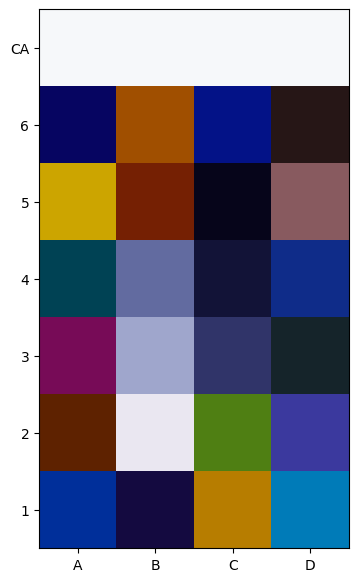

In [27]:
# Plotting the colors
fig, ax = plt.subplots(figsize=(4, 7))

# Create a grid of colors based on the circ_dict keys
color_grid = np.zeros((7, 4, 3))  # Assuming 6 rows and 4 columns for A-F and 1-6

# Fill the color grid with the mean colors from the circ_dict
for key, color in obj_rgb.items():

    if key == 'CA':
        for i in range(4):
            color_grid[0, i, :] = [obj_rgb['CA']['r'], obj_rgb['CA']['g'], obj_rgb['CA']['b']]

    else:
        row_label = key[0]  # Extract the row label (A, B, C, ...)
        col_label = key[1]  # Extract the column label (6, 5, 4, ...)
        row_idx = 7 - int(col_label)  # Calculate the row index (6 maps to 0, 5 maps to 1, etc.)
        col_idx = ord(row_label) - ord('A')  # Calculate the column index (A maps to 0, B maps to 1, etc.)
        color_grid[row_idx, col_idx, :] = [color['r'], color['g'], color['b']]

# Normalize the color values to [0, 1] for displaying with imshow
color_grid /= 255.0

# Display the grid
ax.imshow(color_grid, aspect='auto')

# Set the tick labels
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["A", "B", "C", "D"])
ax.set_yticks(np.arange(7))
ax.set_yticklabels(["CA","6", "5", "4", "3", "2", "1"])

plt.show()

In [33]:
obj_coord_scaled

{'rect_CA': {'y0': 9667, 'y1': 12052, 'x0': 10114, 'x1': 1008},
 'rect_1000': {'y0': 16999, 'y1': 21890, 'x0': 9693, 'x1': 6961},
 'rect_750': {'y0': 18223, 'y1': 21893, 'x0': 5878, 'x1': 3833},
 'rect_500': {'y0': 19458, 'y1': 21903, 'x0': 2795, 'x1': 1430},
 'rect_400': {'y0': 14323, 'y1': 16276, 'x0': 2358, 'x1': 1268},
 'rect_300': {'y0': 14360, 'y1': 15817, 'x0': 4610, 'x1': 3804},
 'A6_1000': {'x_centroid': 9249, 'y_centroid': 17480, 'radius': 256},
 'B6_1000': {'x_centroid': 8633, 'y_centroid': 17481, 'radius': 256},
 'C6_1000': {'x_centroid': 8021, 'y_centroid': 17485, 'radius': 256},
 'D6_1000': {'x_centroid': 7409, 'y_centroid': 17486, 'radius': 256},
 'A5_1000': {'x_centroid': 9250, 'y_centroid': 18260, 'radius': 256},
 'B5_1000': {'x_centroid': 8638, 'y_centroid': 18261, 'radius': 256},
 'C5_1000': {'x_centroid': 8026, 'y_centroid': 18261, 'radius': 256},
 'D5_1000': {'x_centroid': 7410, 'y_centroid': 18266, 'radius': 256},
 'A4_1000': {'x_centroid': 9255, 'y_centroid': 190

In [30]:
len(zarr_storage)

4

In [34]:
with open('/Users/lune/Education/Color/jsons/IHCjul23_020723_obj_coord_1_layer.json', 'w') as fp:
    json.dump(obj_coord_scaled, fp)

In [28]:
f = open('/Users/lune/Education/Color/jsons/IHCjul23_020723_obj_coord_0_layer.json')
obj_coord = json.load(f)

{'r': 0.7543051884824037, 'g': 1.0422636435294663, 'b': 7.2233968563082485}


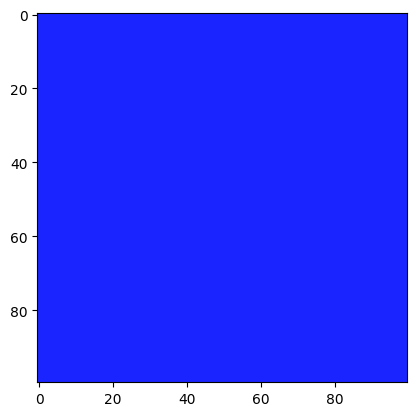

In [247]:
# Given RGB values
color = colors['CA']

# Normalize the values if necessary (assuming max value in given color dict should be scaled down to 1)
max_value = max(color.values())
if max_value > 1:
    normalized_color = {k: v / max_value for k, v in color.items()}
else:
    normalized_color = color

# Extract normalized RGB values
r, g, b = normalized_color['r'], normalized_color['g'], normalized_color['b']

# Create a square image of the color
image = np.zeros((100, 100, 3))
image[:, :] = [r, g, b]

print(color)
# Display the image
plt.imshow(image)